# Classifieur Logistic Regression

La Régression Logistique est un modèle fondamental en apprentissage automatique, particulièrement adapté aux problèmes de classification. Elle est souvent utilisée lorsque la variable dépendante est binaire, ce qui en fait un choix pertinent pour notre tâche de classification des espèces de feuilles. La Régression Logistique modélise la probabilité qu'une observation appartienne à une classe spécifique en utilisant une fonction logistique, offrant ainsi une compréhension intuitive des relations entre les caractéristiques et la variable cible.

In [37]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings

# Ignorer tous les avertissements
warnings.filterwarnings("ignore")

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()


(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 195 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Régression Logistique, nous utilisons également trois hyperparamètres clés :

- La régularisation, contrôlée par le paramètre C. Plus la valeur de C est petite, plus la régularisation est forte.
- Le choix de la norme de pénalité, régulée par le paramètre penalty, qui peut être "l1" (Lasso) ou "l2" (Ridge).
- Le type de solveur utilisé pour l'optimisation, spécifié par le paramètre solver.

Bien que le paramètre de régularisation (C) soit souvent l'hyperparamètre le plus crucial, nous explorons également l'impact des autres hyperparamètres sur les performances du modèle.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

Concernant le paramètre paramètre multi_class, celui-ci permet d'effectuer une régression logisitque sur des données multiclasses et peut prendre deux valeurs :

- 'ovr' (One-vs-Rest) : Cette option entraîne un problème binaire distinct pour chaque classe, considérant cette classe par rapport à toutes les autres. C'est la stratégie par défaut.

- 'multinomial' : Cette option minimise la perte multinomiale sur l'ensemble de la distribution de probabilités, même dans le cas de données binaires. 

Dans notre cas, nous avons choisi de garder le paramètre multi_class en 'auto'. Lorsqu'il est réglé sur 'auto', le modèle sélectionne automatiquement 'ovr' quand le solver est 'liblinear', et passe à 'multinomial' dans le cas contraire. 

In [40]:
# Hyperparamètres pour la Régression Logistique
hyperparameters_lr = {
    'C': [100,125,150],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Entraînement du modèle
grid_lr, results_lr = DM.train_model(LogisticRegression(), hyperparameters_lr, dataset)
print('Best:', grid_lr.best_params_, 'with score {:.3}'.format(grid_lr.best_score_))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: {'C': 150, 'penalty': 'l2', 'solver': 'liblinear'} with score 0.911


### Analyse de l'entrainement

La valeur optimale du paramètre C est de 150, indiquant que notre modèle performe mieux dans le cas où l'inverse de la force régularisation est elevé. Cela signifie que la régularisation est moins contraignante, permettant au modèle de s'ajuster de manière plus flexible aux données d'entraînement, qui dans notre cas, ne sont pas très nombreuses. On peut examiner les performances du modèle en considérant le score associé à ce nombre particulier d'estimateurs et évaluer l'influence des autres hyperparamètres sur ces résultats.

In [52]:
results_lr[results_lr.param_C == grid_lr.best_params_['C']].sort_values(by='rank_test_score')


,param_C,param_penalty,param_solver,mean_test_score,rank_test_score
27,150,l2,liblinear,0.910531,1
25,150,l2,newton-cg,0.910520,2
26,150,l2,lbfgs,0.910520,2
28,150,l2,sag,0.907632,5
29,150,l2,saga,0.900427,13
24,150,l1,saga,0.896121,16
22,150,l1,liblinear,0.880211,21
20,150,l1,newton-cg,NaN,22
21,150,l1,lbfgs,NaN,22
23,150,l1,sag,NaN,22


Nous observons assez facilement que la penalité l2 est celle qui obtient les meilleurs résultats. En effet, elle pénalise les coefficients devenant trop grands, et donc protège du surapprentissage, qui peut d'autaut plus être important lorsque l'on a un grand nombre de classes.

Au niveau des solvers, nous observons qu'ils possèdent des performances assez similaires, et n'ont pas l'air d'avoir d'impacts significatifs sur les performances.

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour voir de façon plus précise l'impact de leur variation sur le score.

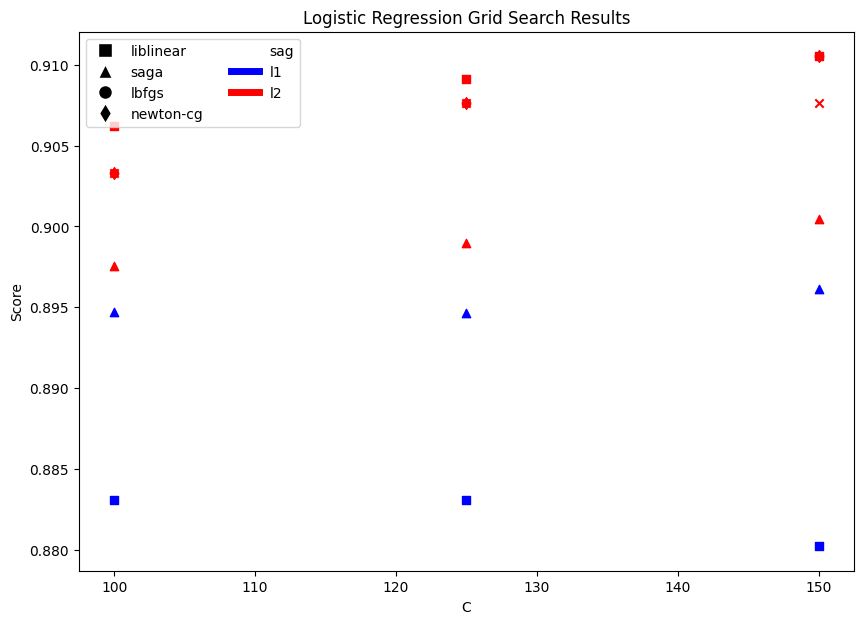

In [48]:
plt.figure(figsize=(10,7))

plt.scatter(results_lr.query('param_solver == "liblinear" and param_penalty == "l1"')['param_C'],
            results_lr.query('param_solver == "liblinear" and param_penalty == "l1" ')['mean_test_score'],
            marker='s', color='blue')
plt.scatter(results_lr.query('param_solver == "liblinear" and param_penalty == "l2" ')['param_C'],
            results_lr.query('param_solver == "liblinear" and param_penalty == "l2" ')['mean_test_score'],
            marker='s', color='red')
plt.scatter(results_lr.query('param_solver == "saga" and param_penalty == "l1" ')['param_C'],
            results_lr.query('param_solver == "saga" and param_penalty == "l1" ')['mean_test_score'],
            marker='^', color='blue')
plt.scatter(results_lr.query('param_solver == "saga" and param_penalty == "l2" ')['param_C'],
            results_lr.query('param_solver == "saga" and param_penalty == "l2" ')['mean_test_score'],
            marker='^', color='red')
plt.scatter(results_lr.query('param_solver == "lbfgs" and param_penalty == "l2" ')['param_C'],
            results_lr.query('param_solver == "lbfgs" and param_penalty == "l2" ')['mean_test_score'],
            marker='o', color='red')
plt.scatter(results_lr.query('param_solver == "newton-cg" and param_penalty == "l2" ')['param_C'],
            results_lr.query('param_solver == "newton-cg" and param_penalty == "l2" ')['mean_test_score'],
            marker='d', color='red')
plt.scatter(results_lr.query('param_solver == "sag" and param_penalty == "l2" ')['param_C'],
            results_lr.query('param_solver == "sag" and param_penalty == "l2" ')['mean_test_score'],
            marker='x', color='red')


plt.xlabel("C")
plt.ylabel("Score")
plt.title("Logistic Regression Grid Search Results")
plt.xticks(np.arange(100, 160, 10))  # Graduations de 1 en 1 sur l'abscisse
legend = [
    plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='liblinear'), 
    plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='saga'), 
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='lbfgs'),
    plt.Line2D([0], [0], marker='d', color='white', markerfacecolor='black', markersize=10, label='newton-cg'),
    plt.Line2D([0], [0], marker='x', color='white', markerfacecolor='black', markersize=10, label='sag'),
    plt.Line2D([0], [0], color='blue', linewidth=5, label='l1'),
    plt.Line2D([0], [0], color='red', linewidth=5, label='l2')
    ]
plt.legend(handles=legend, ncols=2)

plt.show()
plt.show()


Nous observons comme précédemment que le choix du critère l2 donne clairement de meilleures performances que le critère l1, pour les raisons évoquées, surtout au grand nombre de classes et au faible nombre de données présentes dans celles-ci.

Cependant, nous pouvons également observer le paramètre C, l'inverse de la force de régularisation, qui est le plus impactant, et qui dans la plupart des cas fait augmenter le score plus il augmente. Il est à noter nous avons fait de ne fait utiliser des valeurs de C trop élevés car cela augmente considérablement le temps de calcul.

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 93.822% ± 14.766%
   - recall    : 92.929% ± 16.682%
   - f1_score  : 92.350% ± 13.945%
################


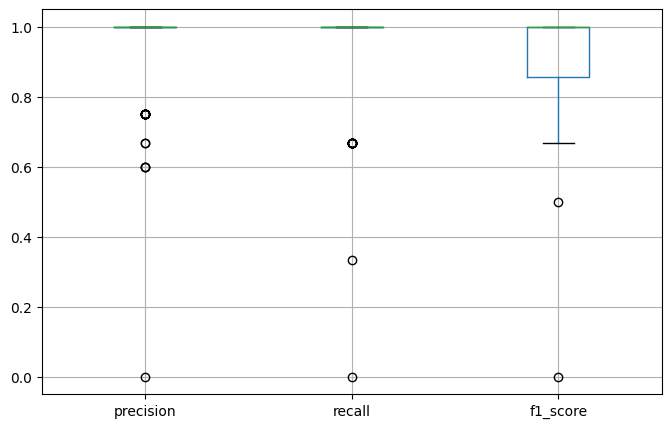

In [49]:
test_preds = grid_lr.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans les boxplots, les prédictions sont parfaites (métriques à 1.0) pour la grande majorité des classes. On peut cependant observer que le boxplot du f1_score est un peu plus étendu, indiquant quelques erreurs de prédictions, mais rien de critique. Il y a cependant des classes pour lesquelles le modèle a moins bien performé. Regardons de quelles classes il s'agit.

In [50]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                             precision    recall  f1_score
Acer_Rubrum                   0.750000  1.000000  0.857143
Alnus_Maximowiczii            0.750000  1.000000  0.857143
Alnus_Sieboldiana             0.666667  0.666667  0.666667
Arundinaria_Simonii           1.000000  0.666667  0.800000
Betula_Pendula                1.000000  0.666667  0.800000
Cornus_Chinensis              1.000000  0.666667  0.800000
Crataegus_Monogyna            1.000000  0.666667  0.800000
Eucalyptus_Glaucescens        0.750000  1.000000  0.857143
Eucalyptus_Neglecta           1.000000  0.333333  0.500000
Fagus_Sylvatica               0.000000  0.000000  0.000000
Liriodendron_Tulipifera       0.600000  1.000000  0.750000
Lithocarpus_Cleistocarpus     0.750000  1.000000  0.857143
Olea_Europaea                 0.750000  1.000000  0.857143
Populus_Grandidentata         1.000000  0.666667  0.800000
Populus_Nigra                 0.600000  1.000000  0.750000
Prunus_Avium                  0.750000  1.000000  0.8571

Pour évaluer les performances de notre modèle de Régression logistique, nous pouvons également utiliser une matrice de confusion pour visualiser les prédictions incorrectes sur l'ensemble de test. La matrice de confusion affiche les classifications réelles par rapport aux classifications prédites, permettant ainsi d'identifier les erreurs et les tendances de notre modèle.

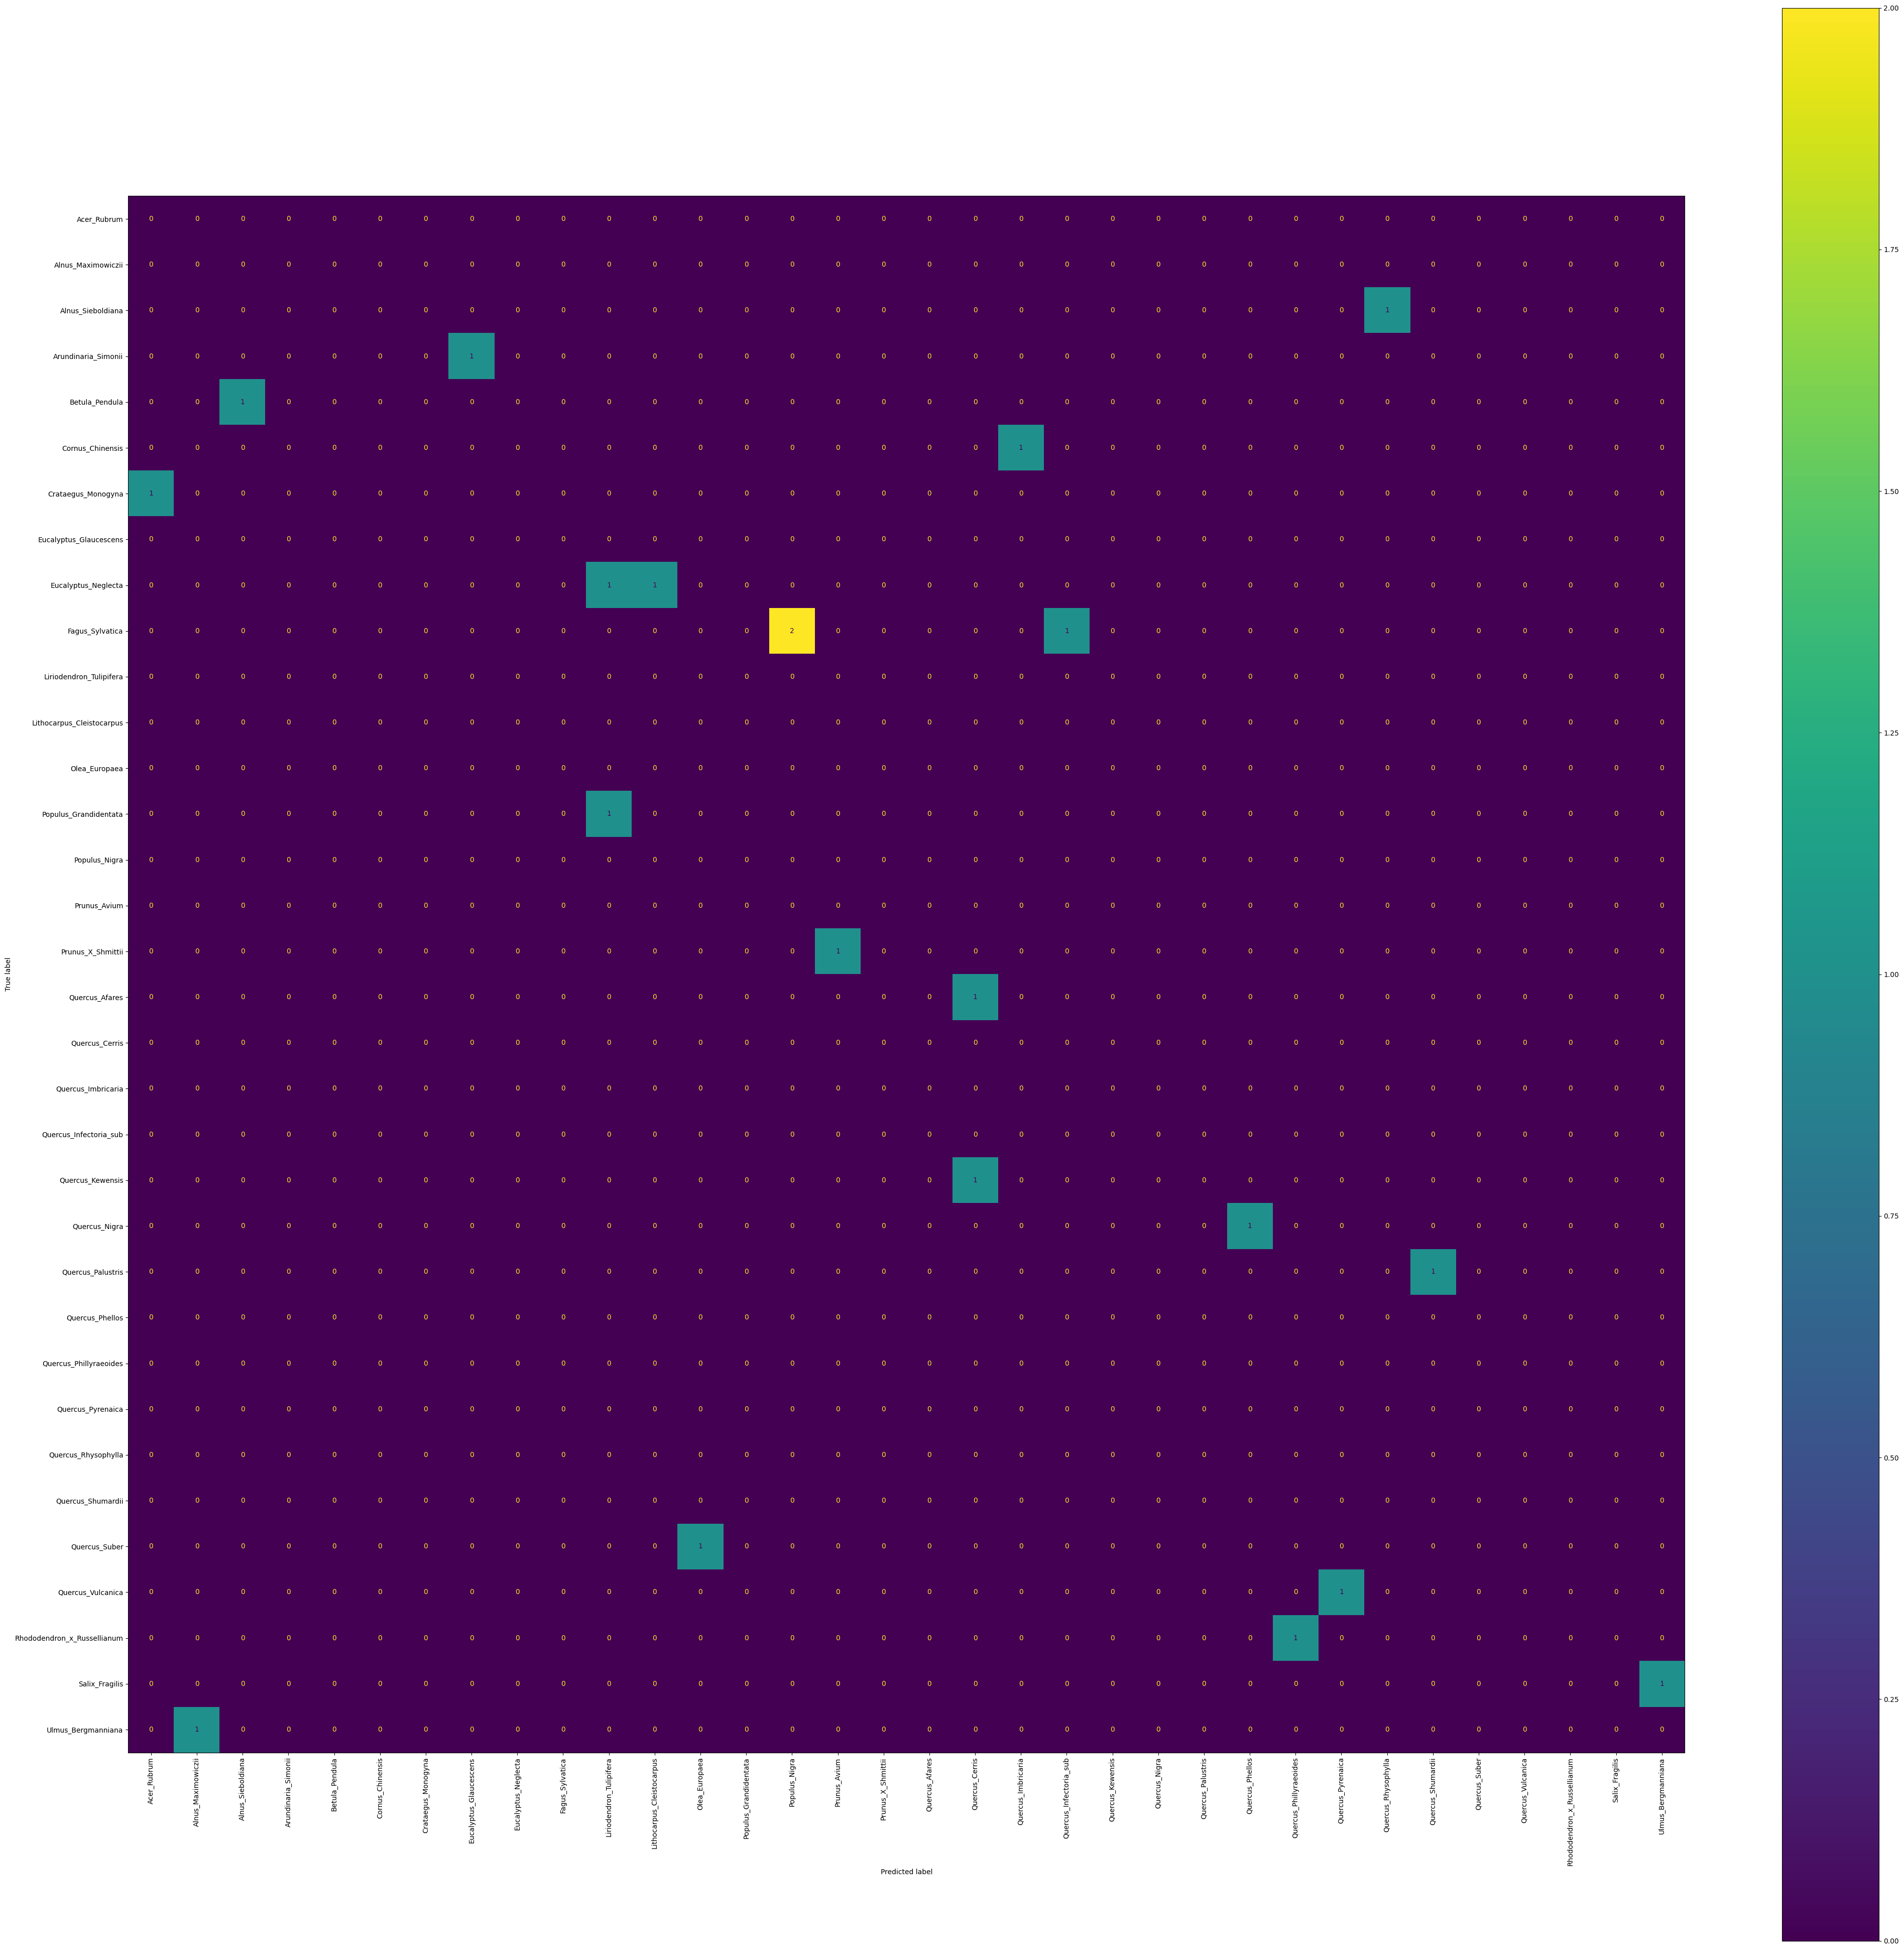

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(50)
display.figure_.set_figheight(50)

plt.show()

Nous observons quelques erreur de prédictions, mais elles restent assez limitées, indiquant que notre modèle performe plutôt bien, même si il n'est pas absolument parfait.

### Conclusion

Pour notre modèle de Régression Logistique, les paramètres optimaux sont définis avec un inverse de la force de régression (C) fixé à 150, une pénalité de type l2, et le solver liblinear. 

Ces paramètres optimisés ont conduit à des résultats très satisfaisants, avec des métriques de performances de l'ordre de 92% à 94%, il est important de noter que le modèle ne peut pas capturer toutes les subtilités du jeu de données. Les performances, bien que solides, laissent entrevoir des marges d'amélioration potentielles.

En conclusion, la Régression Logistique s'avère être un choix approprié pour notre tâche de classification, avec des performances satisfaisantes. Cependant, il aurait pu être possible d'y apporter des améliorations en intensifiant le processus de recherche d'hyperparamètres, mais avec une contre-partie en temps de calcul. Également, il est important de noter que la Régression Logistique est à l'origine faite pour des données binaires, et non multi-classes. Ces résultats soulignent l'importance de choisir des modèles en fonction des caractéristiques spécifiques de l'ensemble de données. 
